## Knowledge Distillation Tutorial

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split 

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#This code is to make sure we have the same output. In addition, it's also to make the code reproducible

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
SEED = 123
set_seed(seed=SEED)

g = torch.Generator()
g.manual_seed(SEED)

Random seed 123 has been set.


In [5]:
#Import dataset. If you haven't download the data, then set the 'download=True'
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST(root='files_mnist/',
                          download=False, train=True, transform=transform)
train, valid = random_split(trainset,[50000,10000])

testset = datasets.MNIST(root='files_mnist/',
                          download=False, train=False, transform=transform)

C:\Users\ASUS\Anaconda3\envs\env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
trainloader = DataLoader(train, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
valloader = DataLoader(valid, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
testloader = DataLoader(testset, batch_size=32, shuffle=False, worker_init_fn=seed_worker, generator=g)

torch.Size([32, 1, 28, 28])
torch.Size([32])


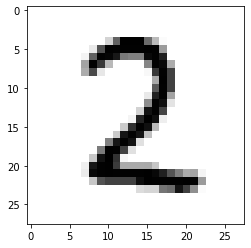

In [7]:
#Check the image 

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## Train teacher model

In [8]:
#Teacher Model
class teacher_net(nn.Module):
    def __init__(self):
        super(teacher_net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [9]:
teacher_model = teacher_net().to(device)
teacher_model

teacher_net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.01)

In [11]:
epochs = 10

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    
    valid_loss = 0.0
    valid_acc = 0.0
    val_total = 0
    
    teacher_model.train()
    for data, labels in trainloader:
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        output = teacher_model(data)
        _, preds = torch.max(output, 1)
        
        loss = loss_fn(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += torch.sum(preds == labels)
        train_total += labels.size(0)
        
    teacher_model.eval()
    for data, labels in valloader:
        data = data.to(device)
        labels = labels.to(device)
        
        output = teacher_model(data)
        _, preds = torch.max(output, 1)
        
        loss = loss_fn(output, labels)
        
        valid_loss += loss.item()
        valid_acc += torch.sum(preds == labels)
        val_total += labels.size(0)
    
    training_loss = train_loss / len(trainloader)
    training_acc = (100 * train_acc) / (train_total)
    validation_loss = valid_loss / len(valloader)
    validation_acc = (100 * valid_acc) / (val_total)
    
    print("Epoch: {}/{} \nTraining Loss:{:.4f} Training Acc:{:.1f} \nValidation Loss:{:.4f} Validation Acc:{:.1f}\n".format(
    epoch, epochs, training_loss, training_acc, validation_loss, validation_acc))

Epoch: 0/10 
Training Loss:1.6886 Training Acc:55.8 
Validation Loss:0.6075 Validation Acc:82.4

Epoch: 1/10 
Training Loss:0.4556 Training Acc:86.8 
Validation Loss:0.3718 Validation Acc:89.4

Epoch: 2/10 
Training Loss:0.3364 Training Acc:90.2 
Validation Loss:0.3041 Validation Acc:91.4

Epoch: 3/10 
Training Loss:0.2786 Training Acc:91.9 
Validation Loss:0.2560 Validation Acc:92.7

Epoch: 4/10 
Training Loss:0.2333 Training Acc:93.4 
Validation Loss:0.2244 Validation Acc:93.6

Epoch: 5/10 
Training Loss:0.1973 Training Acc:94.4 
Validation Loss:0.1890 Validation Acc:94.4

Epoch: 6/10 
Training Loss:0.1700 Training Acc:95.2 
Validation Loss:0.1640 Validation Acc:95.1

Epoch: 7/10 
Training Loss:0.1485 Training Acc:95.8 
Validation Loss:0.1461 Validation Acc:95.6

Epoch: 8/10 
Training Loss:0.1314 Training Acc:96.2 
Validation Loss:0.1389 Validation Acc:95.9

Epoch: 9/10 
Training Loss:0.1174 Training Acc:96.6 
Validation Loss:0.1267 Validation Acc:96.2



In [12]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, labels in testloader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = teacher_model(data)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item() 
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 96.24 %


## Train student model without distillation

In [13]:
#Student Model
class student_net(nn.Module):
    def __init__(self):
        super(student_net, self).__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
student_model = student_net().to(device)
student_model

student_net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(student_model.parameters(), lr=0.01)

In [16]:
epochs = 10

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    
    valid_loss = 0.0
    valid_acc = 0.0
    val_total = 0
    
    student_model.train()
    for data, labels in trainloader:
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        output = student_model(data)
        _, preds = torch.max(output, 1)
        
        loss = loss_fn(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += torch.sum(preds == labels)
        train_total += labels.size(0)
        
    student_model.eval()
    for data, labels in valloader:
        data = data.to(device)
        labels = labels.to(device)
        
        output = student_model(data)
        _, preds = torch.max(output, 1)
        
        loss = loss_fn(output, labels)
        
        valid_loss += loss.item()
        valid_acc += torch.sum(preds == labels)
        val_total += labels.size(0)
    
    training_loss = train_loss / len(trainloader)
    training_acc = (100 * train_acc) / (train_total)
    validation_loss = valid_loss / len(valloader)
    validation_acc = (100 * valid_acc) / (val_total)
    
    print("Epoch: {}/{} \nTraining Loss:{:.4f} Training Acc:{:.1f} \nValidation Loss:{:.4f} Validation Acc:{:.1f}\n".format(
    epoch, epochs, training_loss, training_acc, validation_loss, validation_acc))

Epoch: 0/10 
Training Loss:0.9995 Training Acc:76.7 
Validation Loss:0.4671 Validation Acc:88.2

Epoch: 1/10 
Training Loss:0.4065 Training Acc:89.0 
Validation Loss:0.3604 Validation Acc:89.9

Epoch: 2/10 
Training Loss:0.3449 Training Acc:90.3 
Validation Loss:0.3247 Validation Acc:90.7

Epoch: 3/10 
Training Loss:0.3160 Training Acc:91.0 
Validation Loss:0.3039 Validation Acc:91.3

Epoch: 4/10 
Training Loss:0.2955 Training Acc:91.7 
Validation Loss:0.2870 Validation Acc:91.8

Epoch: 5/10 
Training Loss:0.2784 Training Acc:92.1 
Validation Loss:0.2739 Validation Acc:92.0

Epoch: 6/10 
Training Loss:0.2637 Training Acc:92.6 
Validation Loss:0.2600 Validation Acc:92.6

Epoch: 7/10 
Training Loss:0.2505 Training Acc:93.0 
Validation Loss:0.2477 Validation Acc:92.9

Epoch: 8/10 
Training Loss:0.2385 Training Acc:93.3 
Validation Loss:0.2400 Validation Acc:93.1

Epoch: 9/10 
Training Loss:0.2273 Training Acc:93.6 
Validation Loss:0.2307 Validation Acc:93.5



In [17]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, labels in testloader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = student_model(data)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item() 
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 93.66 %


## Distillation Training

In [18]:
optimizer = optim.SGD(student_model.parameters(), lr=0.01)

In [19]:
def loss_kd(scores, labels, targets, alpha=1, T=1):
    p_s = F.log_softmax(scores/T, dim=1)
    p_t = F.softmax(targets/T, dim=1)
    distill_loss = nn.KLDivLoss()(p_s, p_t) * (T**2) 
    student_loss = F.cross_entropy(scores, labels)
    
    loss = alpha * student_loss + (1. - alpha) * distill_loss
    
    return loss

In [20]:
epochs = 10
temperature = 2
alpha=0.5

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    
    valid_loss = 0.0
    valid_acc = 0.0
    val_total = 0
    
    student_model.train()
    for data, labels in trainloader:
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        scores = student_model(data)
        targets = teacher_model(data)
        
        _, preds = torch.max(scores, 1)
        
        loss = loss_kd(scores, labels, targets, alpha=alpha, T=temperature)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += torch.sum(preds == labels)
        train_total += labels.size(0)
        
    student_model.eval()
    for data, labels in valloader:
        data = data.to(device)
        labels = labels.to(device)
        
        scores = student_model(data)
        targets = teacher_model(data)
        
        _, preds = torch.max(scores, 1)
        
        loss = loss_kd(scores, labels, targets, alpha=alpha, T=temperature)
        
        valid_loss += loss.item()
        valid_acc += torch.sum(preds == labels)
        val_total += labels.size(0)
    
    training_loss = train_loss / len(trainloader)
    training_acc = (100 * train_acc) / (train_total)
    validation_loss = valid_loss / len(valloader)
    validation_acc = (100 * valid_acc) / (val_total)
    
    print("Epoch: {}/{} \nTraining Loss:{:.4f} Training Acc:{:.1f} \nValidation Loss:{:.4f} Validation Acc:{:.1f}\n".format(
    epoch, epochs, training_loss, training_acc, validation_loss, validation_acc))

C:\Users\ASUS\Anaconda3\envs\env\lib\site-packages\torch\nn\functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 0/10 
Training Loss:0.1250 Training Acc:93.9 
Validation Loss:0.1273 Validation Acc:93.6

Epoch: 1/10 
Training Loss:0.1209 Training Acc:94.0 
Validation Loss:0.1248 Validation Acc:93.9

Epoch: 2/10 
Training Loss:0.1174 Training Acc:94.1 
Validation Loss:0.1211 Validation Acc:93.9

Epoch: 3/10 
Training Loss:0.1143 Training Acc:94.3 
Validation Loss:0.1180 Validation Acc:94.0

Epoch: 4/10 
Training Loss:0.1112 Training Acc:94.4 
Validation Loss:0.1167 Validation Acc:94.0

Epoch: 5/10 
Training Loss:0.1085 Training Acc:94.5 
Validation Loss:0.1129 Validation Acc:94.1

Epoch: 6/10 
Training Loss:0.1060 Training Acc:94.6 
Validation Loss:0.1109 Validation Acc:94.1

Epoch: 7/10 
Training Loss:0.1033 Training Acc:94.8 
Validation Loss:0.1083 Validation Acc:94.2

Epoch: 8/10 
Training Loss:0.1010 Training Acc:94.9 
Validation Loss:0.1067 Validation Acc:94.3

Epoch: 9/10 
Training Loss:0.0988 Training Acc:95.0 
Validation Loss:0.1045 Validation Acc:94.4



In [21]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, labels in testloader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = student_model(data)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item() 
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 94.63 %
